# <center>Application of Ant Colony Optimization in FSP problem</center>

This notebook presents a practical approach to solving the flowshop problem by implementing the Ant Colony Optimization algorithm. These metaheuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources. Compared to heuristics, such metaheuristics are more effective for solving the flowshop problem because they can escape from local optima and find better solutions




## Data utils

In [121]:
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from utils.benchmarks import benchmarks
from utils.heuristics import *

### Path Cost calculation function :
Used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [122]:
def calculate_makespan(processing_times, sequence):
    n_jobs = len(sequence)
    n_machines = len(processing_times[0])
    end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

    for j in range(1, n_jobs + 1):
        for m in range(1, n_machines + 1):
            end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1]
                                 [m]) + processing_times[sequence[j - 1]][m - 1]

    return end_time[n_jobs][n_machines]

### Gantt graph generator

In [123]:
def generate_gantt_chart(processing_times, seq, interval=50, labeled=True):
    data = processing_times.T
    nb_jobs, nb_machines = processing_times.shape
    schedules = np.zeros((nb_machines, nb_jobs), dtype=dict)
    # schedule first job alone first
    task = {"name": "job_{}".format(
        seq[0]+1), "start_time": 0, "end_time": data[0][seq[0]]}

    schedules[0][0] = task
    for m_id in range(1, nb_machines):
        start_t = schedules[m_id-1][0]["end_time"]
        end_t = start_t + data[m_id][0]
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": start_t, "end_time": end_t}
        schedules[m_id][0] = task

    for index, job_id in enumerate(seq[1::]):
        start_t = schedules[0][index]["end_time"]
        end_t = start_t + data[0][job_id]
        task = {"name": "job_{}".format(
            job_id+1), "start_time": start_t, "end_time": end_t}
        schedules[0][index+1] = task
        for m_id in range(1, nb_machines):
            start_t = max(schedules[m_id][index]["end_time"],
                          schedules[m_id-1][index+1]["end_time"])
            end_t = start_t + data[m_id][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][index+1] = task

    # create a new figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # set y-axis ticks and labels
    y_ticks = list(range(len(schedules)))
    y_labels = [f'Machine {i+1}' for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # calculate the total time
    total_time = max([job['end_time'] for proc in schedules for job in proc])

    # set x-axis limits and ticks
    ax.set_xlim(0, total_time)
    x_ticks = list(range(0, total_time+1, interval))
    ax.set_xticks(x_ticks)

    # set grid lines
    ax.grid(True, axis='x', linestyle='--')

    # create a color dictionary to map each job to a color
    color_dict = {}
    for proc in schedules:
        for job in proc:
            if job['name'] not in color_dict:
                color_dict[job['name']] = (np.random.uniform(
                    0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))

    # plot the bars for each job on each processor
    for i, proc in enumerate(schedules):
        for job in proc:
            start = job['start_time']
            end = job['end_time']
            duration = end - start
            color = color_dict[job['name']]
            ax.barh(i, duration, left=start, height=0.5,
                    align='center', color=color, alpha=0.8)
            if labeled:
                # add job labels
                label_x = start + duration/2
                label_y = i
                ax.text(
                    label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

    plt.show()

### ACO for FSP

In [124]:
class AntColonyOptimization:

    def __init__(self, processingTimes, Alpha=.5, Beta=.5, Q=.9, max_it=10, num_ant=16, rho=0, heuristicSolution =[]) -> None:

        self.numberJobs = processingTimes.shape[0]
        self.numberMachines = processingTimes.shape[1]
        self.Distances = np.zeros((self.numberJobs, self.numberJobs))
        self.processingTimes = processingTimes
        self.archive = heuristicSolution
        self.alpha = Alpha
        self.beta = Beta
        self.Q = Q
        self.globalPheromone = np.ones((self.numberJobs, self.numberJobs))
        self.maxIt = max_it
        self.numAnt = num_ant
        self.rho = rho


    def calculateDistances(self):
        for i in range(self.numberJobs):
            for j in range(self.numberJobs):
                if (i == j):
                    self.Distances[i, j] =0
                else : 
                    for k in range(self.numberMachines-1):
                         self.Distances[i, j] += self.processingTimes[j, k] + max(0, self.processingTimes[i, k+1]- self.processingTimes[j, k])
                    self.Distances[i, j] += self.processingTimes[j, self.numberMachines-1]  


    # calcule la formule de choix du job à prendre 
    def calculateJobVoisin(self, jobCourant, lePotentielJobVoisin, lesPotentielsJobsVoisins):
        denominateur = 0
        numerateur = 0

        for i in range(len(lesPotentielsJobsVoisins)):
            denominateur += (self.globalPheromone[jobCourant, lesPotentielsJobsVoisins[i]])**self.alpha * (1/self.Distances[jobCourant, lesPotentielsJobsVoisins[i]])**self.beta
        numerateur =  (self.globalPheromone[jobCourant, lePotentielJobVoisin])**self.alpha * (1/self.Distances[jobCourant, lePotentielJobVoisin])**self.beta

        # print("numerateur", numerateur)

        # print("denom", denominateur)

        return numerateur/denominateur


    def updateLocalPheromone(self, solutionSequence, localPheromoneMatrix):

        solutionQuality = calculate_makespan(self.processingTimes, solutionSequence)

        for j in range(len(solutionSequence)-1):

            localPheromoneMatrix[solutionSequence[j], solutionSequence[j+1]] += self.Q /solutionQuality
   

    def updateGlobalPheromone(self, localPheromoneMatrix):

        self.globalPheromone = (1-self.rho)*self.globalPheromone + localPheromoneMatrix          
    

    def run(self):

        start_time = time.time()

        self.calculateDistances()

        for it in range(self.maxIt):

            #liste de liste pour contenir les solutions de chaque fourmi

            solutions = []

            localPheromone = np.zeros((self.numberJobs, self.numberJobs))


            for ant in range(self.numAnt): 

                solutions.append([])

                num_job_pris = 0

                #initialisation de la liste contenant les jobs qui constitueront la solution, elle sera updaté à chaque fois qu'un job est pris

                job_dispo = list(range(self.numberJobs))

                # démarrer par un job aléatoirement

                solutions[ant].append(job_dispo[random.randint(0, len(job_dispo) - 1)])
                

                #updating ce qu'il faut

                job_dispo.remove(solutions[ant][num_job_pris])

                num_job_pris +=1

                while(len(job_dispo)>0): # équivaut à dire num_job_pris < self.numberJobs

                    bestVoisin = 0

                    nextJob = None

                    for i in range(len(job_dispo)):

                        #solutions[ant][num_job_pris-1] is the current node

                        voisinActuel = self.calculateJobVoisin(solutions[ant][num_job_pris-1], job_dispo[i], job_dispo)

                        if( voisinActuel > bestVoisin):

                            bestVoisin = voisinActuel

                            nextJob = job_dispo[i]


                    solutions[ant].append(nextJob)

                    #updating ce qu'il faut

                    job_dispo.remove(nextJob)

                    num_job_pris +=1

                #Mise à jour local de phéromone

                self.updateLocalPheromone(solutions[ant], localPheromone) 

                # print("Ant : ", ant, "'s solution : ", solutions[ant]) 

                # print("Its makespan is : ", calculate_makespan(self.processingTimes, solutions[ant]))

            #Mise à jour globale de phéromone 

            self.updateGlobalPheromone(localPheromone)

            # L'idée que j'ai est de calculer le makespan de toutes les solutions et si une est meilleure de celle contenu dans l'archive l'archiver à son tour 

            for sol in range(len(solutions)):

                makespan = calculate_makespan(self.processingTimes, solutions[sol])

                if (makespan < calculate_makespan(self.processingTimes, self.archive)):

                    self.archive = solutions[sol]
                
        print("Elapsed time:", time.time()-start_time, "seconds")

        #Retourner la meilleure solution 

        return self.archive  


In [125]:
algorithms = {
    "NEH":  neh_algorithm,
    "Ham":  ham_heuristic,
    "CDS":  cds_heuristic,
    "Gupta": gupta_heuristic,
    "Palmer":  run_palmer,
    "PRSKE":  PRSKE,
    "Weighted CDS": special_heuristic,
    "NRH": NRH,
    "Chen": chen_heuristic
    }


In [126]:
def generate_heuristic_solution(processing_times ,name = "NEH" ):
    return algorithms[name](processing_times)[0]

## Tests

In [127]:

processing_times = benchmarks[0]
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan : ", calculate_makespan(processing_times, initial_solution))

ACO = AntColonyOptimization(processing_times, Alpha=10, Beta=1, Q=1, max_it=1, num_ant=1, rho=0, heuristicSolution=initial_solution)
result = ACO.run()

print("Solution : ",result)
print("Makespann " , calculate_makespan(processing_times, result))

Initial solution :  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]
Makespan :  1593
Elapsed time: 0.007054567337036133 seconds
Solution :  [4, 12, 2, 16, 14, 7, 8, 13, 19, 11, 10, 18, 5, 9, 6, 0, 1, 17, 15, 3]
Makespann  1423


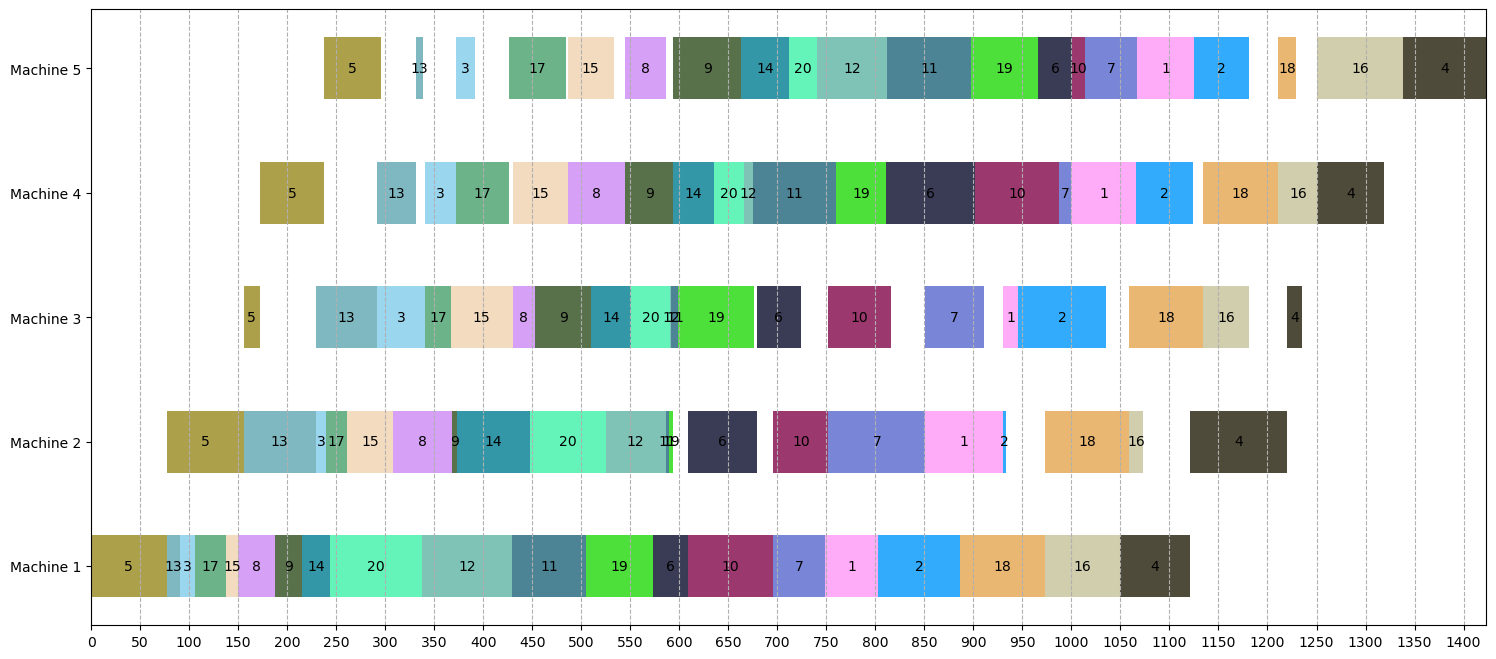

In [128]:
generate_gantt_chart(processing_times,result)

## Meilleurs Hyper Parameters

In [129]:
# Définir l'espace des paramètres
space = [
    Real(0.5, 0.9, name='alpha'),
    Real(0.5, 0.9, name='beta'),
    Real(0.1, 0.9, name='Q'),
    Integer(10, 40, name='it_max'),
    Integer(10, 100, name='num_ant'),
    Real(0.1, 0.9, name='rho'),
]

# Fonction objectif à minimiser


@use_named_args(space)
def objective(**params):
    alpha = params['alpha']
    beta = params['beta']
    Q = params['Q']
    it_max = params['it_max']
    num_ant = params['num_ant']
    rho = params['rho']
   

    ACO = AntColonyOptimization(
    processing_times, Alpha=alpha, Beta=beta, Q=Q, max_it=it_max, num_ant=num_ant, rho=rho, heuristicSolution=initial_solution)
    
    result = ACO.run()
    
    return calculate_makespan(processing_times, result)


# Lancer l'optimisation
result = gp_minimize(objective, space, n_calls=20, random_state=0)
# Affichage des meilleurs paramètres trouvés

best_alpha = result.x[0]
best_beta  = result.x[1]
best_Q = result.x[2]
best_it_max = result.x[3]
best_num_ant = result.x[4]
best_rho = result.x[5]


Elapsed time: 6.0433104038238525 seconds
Elapsed time: 4.947545289993286 seconds
Elapsed time: 3.1355223655700684 seconds
Elapsed time: 4.7651684284210205 seconds
Elapsed time: 1.6329498291015625 seconds
Elapsed time: 1.3429248332977295 seconds
Elapsed time: 3.740278482437134 seconds
Elapsed time: 1.5499176979064941 seconds
Elapsed time: 6.866034269332886 seconds
Elapsed time: 2.8997137546539307 seconds
Elapsed time: 6.509196758270264 seconds
Elapsed time: 1.8869082927703857 seconds
Elapsed time: 3.616468667984009 seconds
Elapsed time: 3.43629789352417 seconds
Elapsed time: 3.6149063110351562 seconds
Elapsed time: 0.399869441986084 seconds
Elapsed time: 3.6353635787963867 seconds
Elapsed time: 3.9626846313476562 seconds
Elapsed time: 1.0458362102508545 seconds
Elapsed time: 4.113761901855469 seconds


In [130]:
ACO = AntColonyOptimization(

    processing_times, Alpha=best_alpha, Beta=best_beta, Q=best_Q, max_it=best_it_max, num_ant=best_num_ant, rho=best_rho, heuristicSolution=initial_solution)

result = ACO.run()

print("Solution : ", result)
print("Makespann ", calculate_makespan(processing_times, result))

Elapsed time: 3.692780017852783 seconds
Solution :  [4, 3, 2, 12, 19, 16, 14, 7, 8, 13, 15, 5, 18, 0, 1, 6, 17, 11, 10, 9]
Makespann  1367


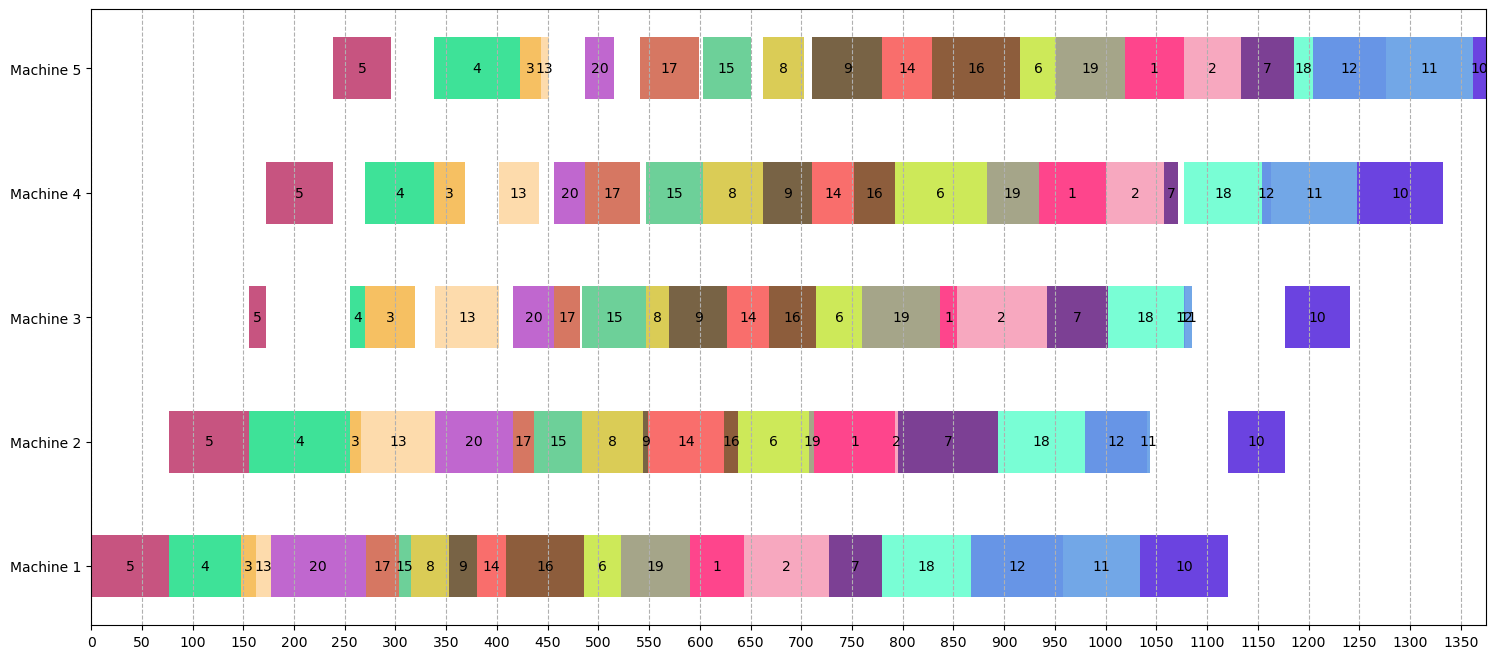

In [131]:
generate_gantt_chart(processing_times,result)